In [33]:
#| echo: false 
#| output: false
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import os 
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Differential Equations

We're going to take a small detour through ordinary differential equations (ODEs).
ODEs, and their stochastic counterparts, Stochastic Differential Equations (SDEs),
are an important technical advance in score-based generative modelling.
In this section, we're going to see how to use SDEs to noise up data,
thereby replacing the noising step,
and reverse-time versions of the SDEs to generate new data,
thereby replacing the annealed Langevin dynamics step.

## Ordinary differential equations

Let's start with ODEs.
ODEs are usually taught in undergraduate calculus classes,
since they involve differentiation and integration.
I do remember encountering them in high school in Singapore,
which is a testament to how advanced the mathematics curriculum in Singapore is.

ODEs are useful models of systems
where we believe that the rate of change of an output variable
is a math function of some input variable.
In abstract mathematical symbols:

$$\frac{dy}{dx} = f(x, \theta)$$

Here, $f$ simply refers to some mathematical function of $x$
and the function's parameters $\theta$.

### A classic ODE example

A classic ODE example that we might think of is that of a decay curve:

$$\frac{dy}{dt} = -y$$

Implemented in `diffrax`, which is a JAX package for differential equations,
and wrapped in Equinox as a parameterized function,
we have the following code:

In [34]:
from diffrax import diffeqsolve, Tsit5, ODETerm, SaveAt
import jax.numpy as np
from jax import vmap
import equinox as eqx


def exponential_decay_drift(t: float, y: float, args: tuple):
    """Exponential decay drift term."""
    return -y


class ODE(eqx.Module):
    drift: callable

    def __call__(self, ts: np.ndarray, y0: float):
        term = ODETerm(self.drift)
        solver = Tsit5()
        saveat = SaveAt(ts=ts, dense=True)
        sol = diffeqsolve(
            term, solver, t0=ts[0], t1=ts[-1], dt0=ts[1] - ts[0], y0=y0, saveat=saveat
        )
        return vmap(sol.evaluate)(ts)


For those of us who have learned about ODEs, 
the structure of the code above should look pretty familiar.
The diffrax API neatly organizes what we need to solve ODEs:

- the `ODETerm`, which is the $\frac{dy}{dt}$ equation,
- a `solver`, for which `diffrax` provides a library of them,
- the initial and end points $t_0$ and $t_1$ along the $t$ axis along with step size $dt$,
- the initial value of $y$, i.e. $y_0$.

Finally, when calling on the ODE,
we evaluate the solution path from the starting time to the ending time,
given an initial starting value.


In [35]:
ode = ODE(exponential_decay_drift)
ts = np.linspace(0, 10, 1000)
ys = ode(ts=ts, y0=3)


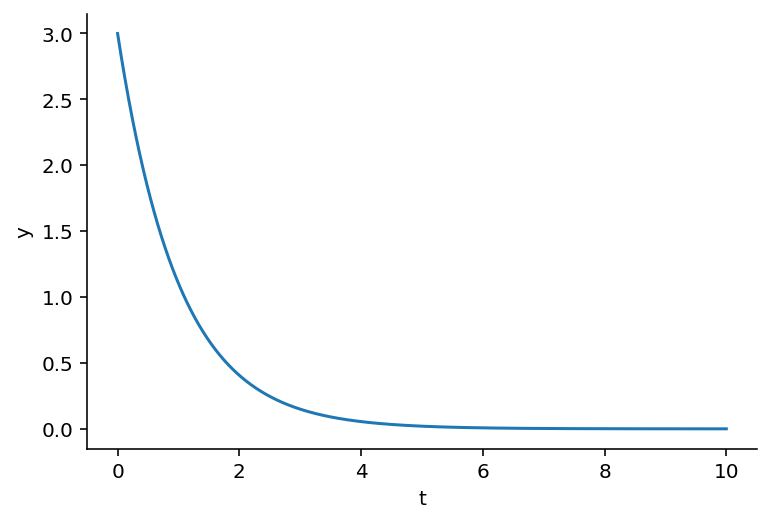

In [36]:
#| code-fold: true 
#| fig-cap: Solution to the ODE $f'(y) = -y$.
#| label: fig-ode-exponential-decay
import matplotlib.pyplot as plt 
import seaborn as sns

plt.plot(ts, ys)
plt.xlabel("t")
plt.ylabel("y")
sns.despine()


The solution of the ODE that we had above is an exponential decay,
and that is exactly what we see in the curve above.

And if we wanted to run the ODE from multiple starting points:

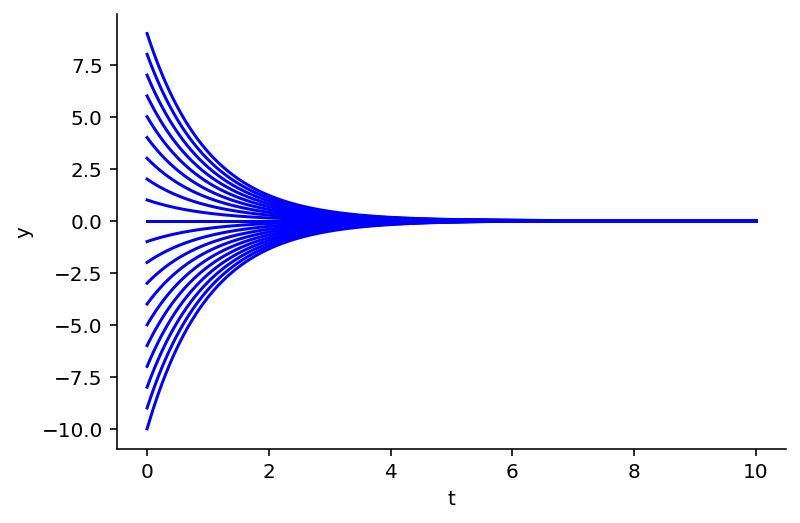

In [37]:
#| code-fold: true
#| fig-cap: Multiple solutions to the ODE $f'(y) = -y$.
#| label: fig-ode-multiple-decay

ys = ode(ts=ts, y0=np.arange(-10, 10))

for curve in ys.T:
    plt.plot(ts, curve, color="blue")
plt.xlabel("t")
plt.ylabel("y")
sns.despine()

## Stochastic Differential Equations

Stochastic differential equations (SDEs) extend ODEs
by adding in noise into each step. 
SDEs can thus be thought of as having a "drift" component,
in which the system being modeled by the SDE "drifts" through the vector field,
and a "diffusion" component,
in which the system's state is perturbed with additional noise.
SDEs have the general form:

$$dx = f(x, t)dt + g(t)dw$$


To paraphrase Yang's blog post, here are the definitions of each of the terms.

- $f(x, t)$ is a drift function that produces a vector output, 
  i.e. what would have been the ODE term. 
  This term controls the "drift"-ing of the system in observed data space.
- $g(t)$ is a diffusion function that produces a scalar output, 
  i.e. the scalar multiplier of $dw$.
  This term adds "diffusive" noise to the output.
- $dw$ is the infinitesimal white noise term.

$f(x, t)dt$ is usually referred to as the "ODE Term",
while $g(t)dw$ is usually referred to as the "Control Term".
We can see that in the implementation of the SDE module below.

In [38]:
from jax import random
import jax.numpy as np
from diffrax import (
    ControlTerm,
    MultiTerm,
    VirtualBrownianTree,
    Heun
)

class SDE(eqx.Module):
    drift: callable
    diffusion: callable

    def __call__(self, ts: np.ndarray, y0: float, key: random.PRNGKey):
        brownian_motion = VirtualBrownianTree(ts[0], ts[-1], tol=1e-3, shape=(), key=key)
        terms = MultiTerm(ODETerm(self.drift), ControlTerm(self.diffusion, brownian_motion))
        solver = Heun()
        saveat = SaveAt(t0=True, ts=ts, dense=True)
        sol = diffeqsolve(terms, solver, t0=ts[0], t1=ts[-1], dt0=ts[1] - ts[0], y0=y0, saveat=saveat)
        return vmap(sol.evaluate)(ts)


### Noisy Decay

For illustration, 
let's see what happens we we apply homoskedastic noise to the decay process.
Here, homoskedastic noise refers to a noise term that is _independent_ of time.
Firstly, we have it defined in code.

In [39]:
from functools import partial

def homoskedastic_diffusion(t, y, args):
    """Time-independent noise."""
    return 0.3


Next, we set up the SDE and solve it going forward in time.

In [40]:
n_timesteps = 17
n_starting = 1001

demo_key = random.PRNGKey(55)

y0_key, key = random.split(demo_key)
y0s = random.normal(y0_key, shape=(n_starting,))  # We solve the SDE for each draw from a Guassian.

sde_keys = random.split(key, len(y0s))
ts = np.linspace(0, 4, n_timesteps)
sde = SDE(drift=exponential_decay_drift, diffusion=homoskedastic_diffusion)
sde = partial(sde, ts)
ys = vmap(sde)(y0s, sde_keys)


Now, let's plot the trajectories:

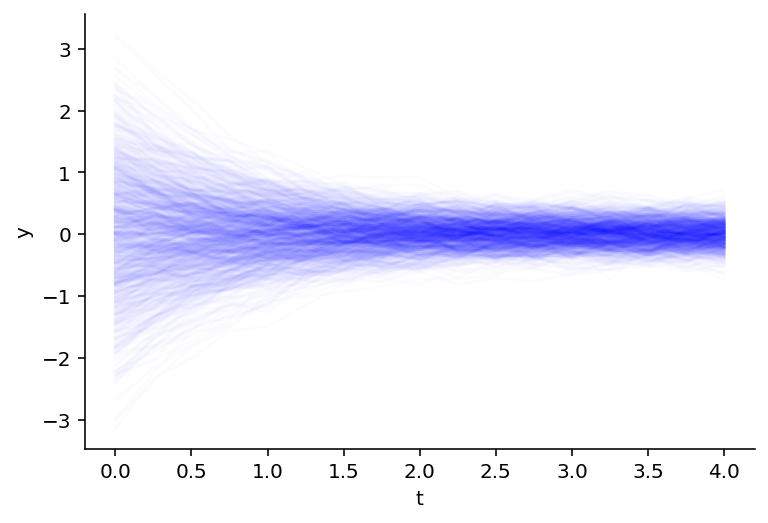

In [41]:
#| code-fold: true
#| label: fig-sde-decay-homoskedastic
#| fig-cap: SDE with exponential decay drift and homoskedastic disffusion.
for y in ys:
    plt.plot(ts, y, alpha=0.01, color="blue")

plt.xlabel("t")
plt.ylabel("y")
sns.despine()

### Oscillating SDE 

Let's do another example: oscillating SDEs!
Here, we have an oscillating system (cosine drift)
in which we add a homoskedastic diffusion term.

In [42]:
def cosine_drift(t, y, args):
    return np.cos(t)


sde = SDE(drift=cosine_drift, diffusion=homoskedastic_diffusion)
ts_oscillating = np.linspace(1, 10, n_timesteps)
sde = partial(sde, ts_oscillating)
keys = random.split(key, 1001)
oscillating_y0s = random.normal(key, shape=(1001,)) * 0.1
oscillating_ys = vmap(sde)(oscillating_y0s, keys)


Likewise, let's plot this one too:


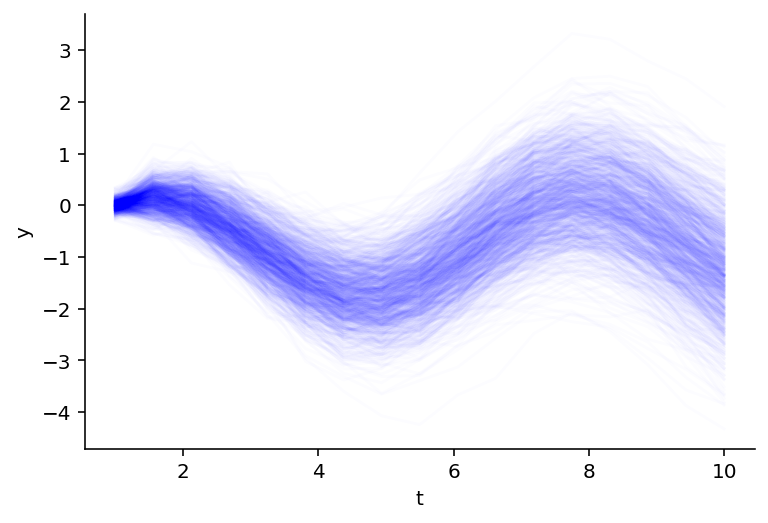

In [43]:
#| code-fold: true
#| label: fig-sde-oscillating-homoskedastic
#| fig-cap: SDE with exponential decay drift and homoskedastic disffusion.

for y in oscillating_ys:
    plt.plot(ts_oscillating, y, color="blue", alpha=0.01)

plt.xlabel("t")
plt.ylabel("y")
sns.despine()


At each timepoint, there is also a marginal distribution.
Let's inspect that below.

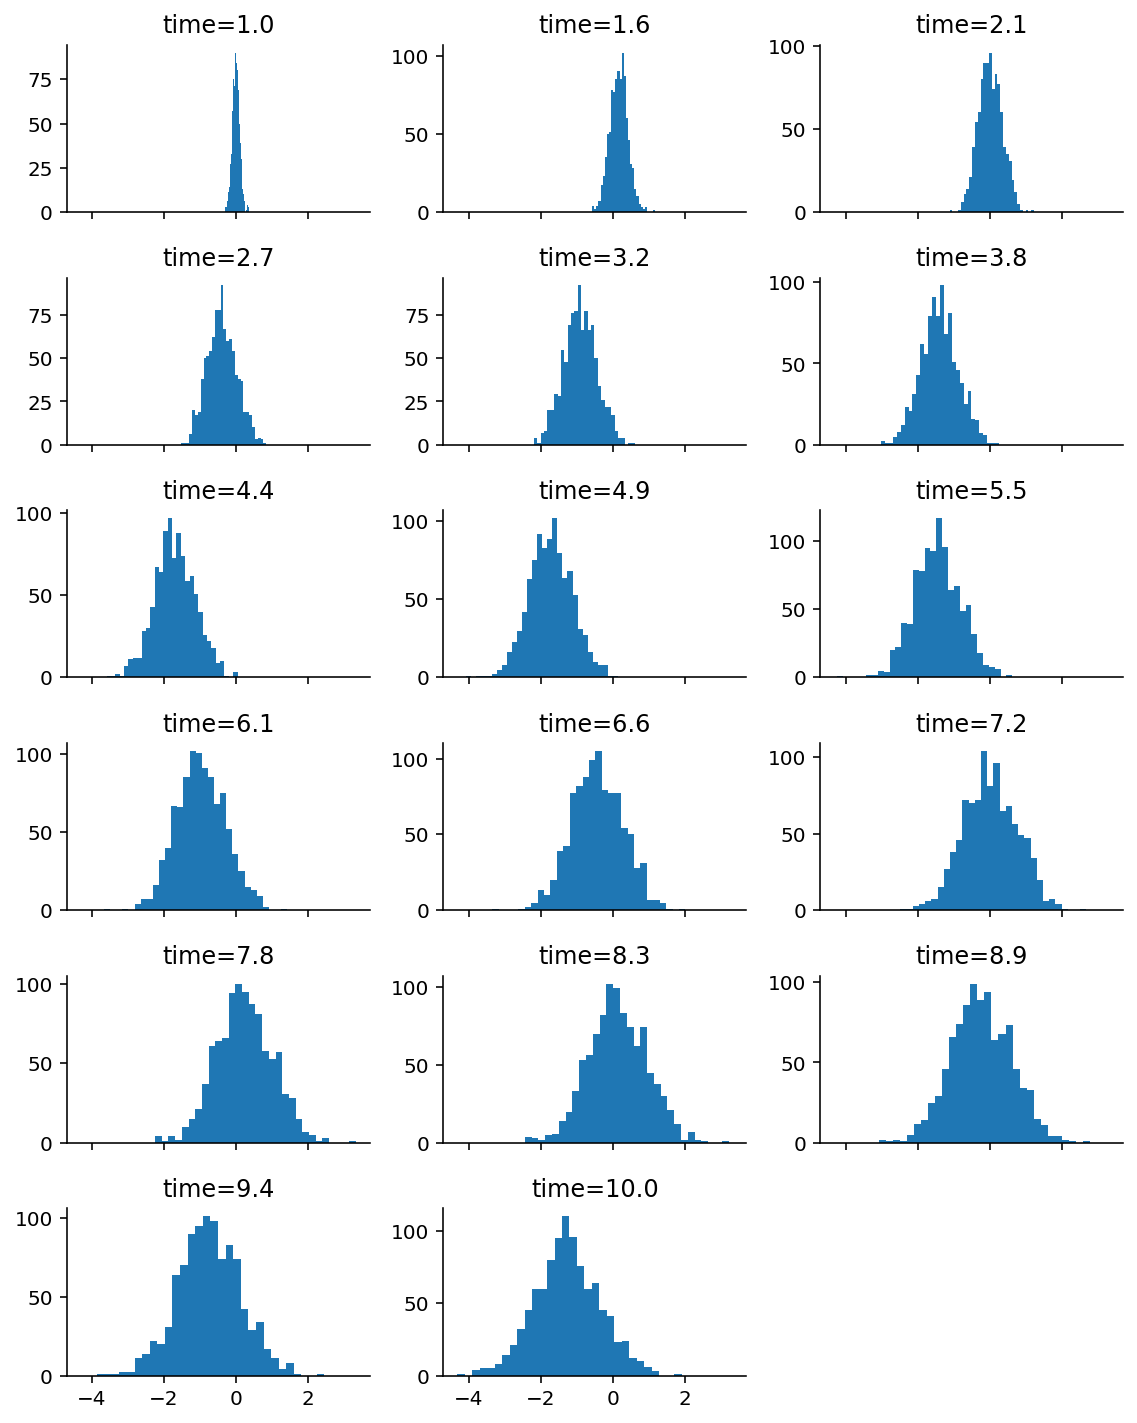

In [44]:
#| code-fold: true
#| label: fig-sde-oscillating-marginals
#| fig-cap: Marginal distribution at each time point of the oscillating SDE.

import numpy as onp
fig, axes = plt.subplots(figsize=(8, 10), nrows=6, ncols=3, sharex=True)
axes = axes.flatten()

for ax, t, y in zip(axes, ts_oscillating, oscillating_ys.T):
    plt.sca(ax)
    plt.hist(onp.array(y), bins=30)
    plt.title(f"time={t:.1f}")

sns.despine()
plt.delaxes(axes[-1])
plt.tight_layout()


### Noising SDE

For the purposes of noising up date,
we would want an SDE that noises up data with increasing amounts of noise with time.
Here, we can design the SDE such that the drift would be 0 at all time points,
while the diffusion term would be some multiplier on time.

In [45]:
def constant_drift(t, y, args):
    """Constant drift term."""
    return 0

def time_dependent_diffusion(t, y, args):
    """Diffusion term that increases with time."""
    return 0.3 * t


As always, we set up the SDE:

In [46]:
sde = SDE(drift=constant_drift, diffusion=time_dependent_diffusion)
ts_noising = np.linspace(0, 4, n_timesteps)
sde = partial(sde, ts_noising)
y0s = random.normal(key, shape=(n_starting,)) * 0.1  # we start with N(0, 0.1) draws.
keys = random.split(key, n_starting)
noising_ys = vmap(sde)(y0s, keys)


Then let's plot the solved SDE trajectories:

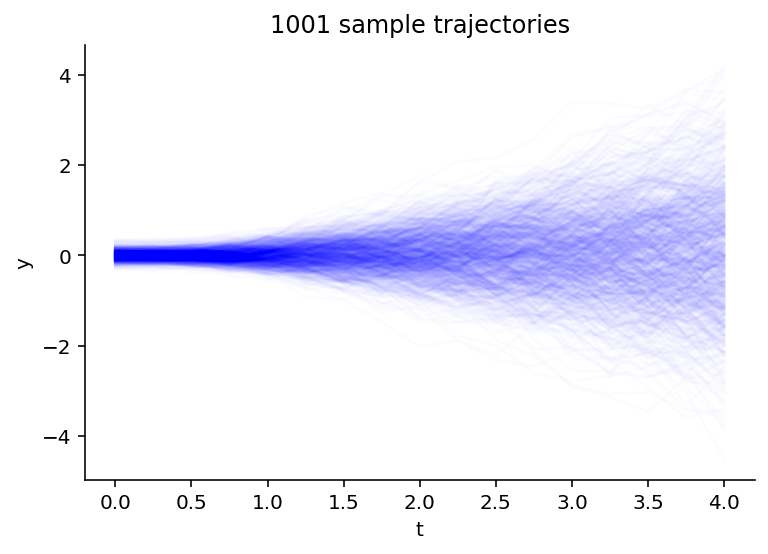

In [47]:
#| code-fold: true
#| label: fig-noising-sde
#| fig-cap: A "noising" SDE that progressively adds more noise over time.
for y in noising_ys:
    plt.plot(ts_noising, y, color="blue", alpha=0.01)
    plt.xlabel("t")
    plt.ylabel("y")
    plt.title(f"{n_starting} sample trajectories")
    sns.despine()


As we can see above, 
we are able to obtain greater amounts of noise from a tight starting point.
We can verify that by looking at the marginal distributions.

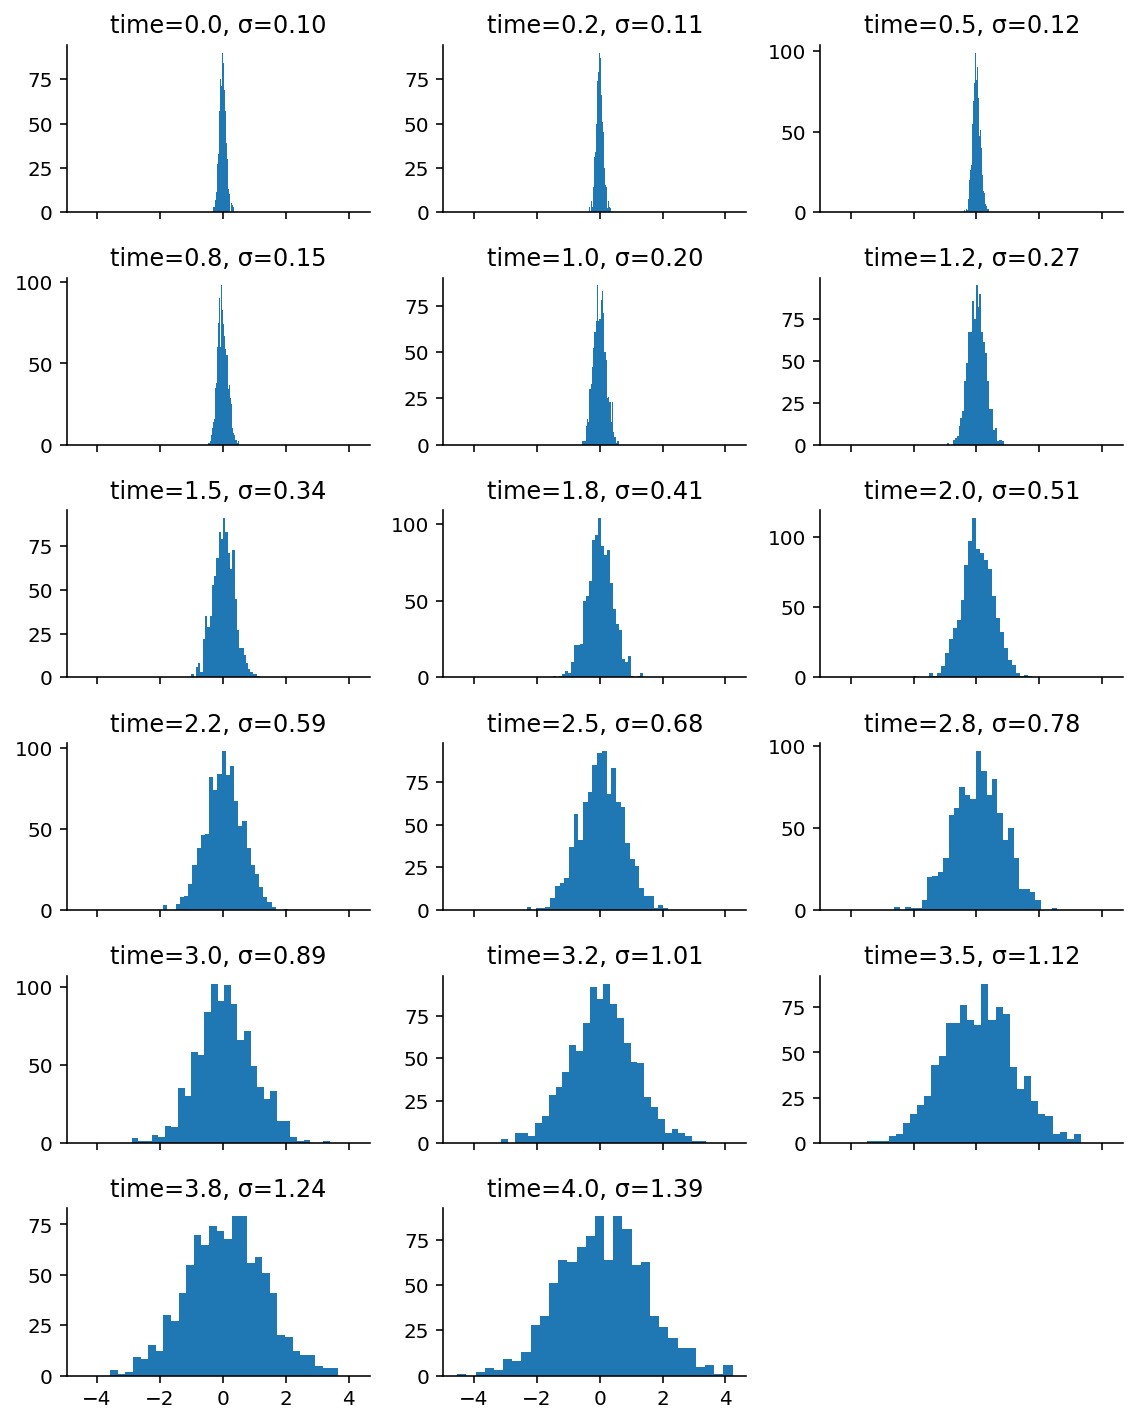

In [48]:
#| code-fold: true
#| label: fig-sde-noising-marginals
#| fig-cap: Marginal distribution at each time point of a noising SDE.

import numpy as onp
fig, axes = plt.subplots(figsize=(8, 10), nrows=6, ncols=3, sharex=True)
axes = axes.flatten()

for ax, t, y in zip(axes, ts_noising, noising_ys.T):
    plt.sca(ax)
    plt.hist(onp.array(y), bins=30)
    plt.title(f"time={t:.1f}, σ={onp.std(y):.2f}")

sns.despine()
plt.delaxes(axes[-1])
plt.tight_layout()


From the marginal distributions at each noise timestep,
we see that we indeed have ever increasing amounts of noise.
(Note how the x-axis scale is the same on all of the plots.)
The empirical standard deviation from the mean is also shown on the plots above.

## Reverse Time SDEs

With constant drift and time-dependent diffusion,
we can noise up data in a continuous fashion.
How do we go backwards?
Here is where solving the reverse time SDE will come in. 
Again, we need to set up the drift and diffusion terms.
Here, the drift term is:

$$f(x, t) - g^2(t) \nabla_x \log p_t (x) $$

where:

- $f(x, t)$ is the drift term of the forward SDE,
- $g(t)$ is the diffusion term of the forward SDE, and
- $\nabla_x \log p_t (x)$ is the score function of the data.


And the diffusion term is:

$$g(t) dw$$

which is basically the diffusion term of the forward SDE.

However, the tricky part here is that we don't have access to
$\nabla_x \log p_t (x)$ (the true score function).
As such, we need to bring out our score model approximator!
To train the score model approximator,
we need the analogous score matching objective for continuous time problems.

In an ideal situation,
we would train the score matching model
using a weighted combination of Fisher divergences:

$$\mathbb{E}_{t \in U(0, T)} \mathbb{E}_{p_t(x)} [ \lambda(t) || \nabla_x \log p_t(x) - s_{\theta}(x, t) ||^2_2]$$

Now, just like before, we don't have access to $\nabla_x \log p_t (x)$,
so we instead use the score matching objective by Hyvärinen.
What's really cool here is that we can train the models using the noised up data.
The protocol is basically as follows:

1. Noise up our original data using an SDE.
2. Train score models to estimate the score function of the noised up data.
3. Use the approximate score function to calculate the reverse-time SDE.

To get this right, we need a score function approximator that is compatible with SDEs,
i.e. they accept both `x` and `t` as part of the function signature
and return the gradient value.

```python
score: float = score_model(x, t) 
```

Let's implement it below:

In [49]:
from jax import jacfwd
from jax import nn
import equinox as eqx

class SDEFeedForwardModel1D(eqx.Module):
    r"""Time-dependent Gaussian score function.

    Key trick here is to make the parameters $\mu$ and $\log(\sigma)$ depend on $t$,
    i.e. the time at which a Gaussian was sampled.
    """

    mlp: eqx.Module

    def __init__(
        self,
        in_size=2,
        out_size=1,
        width_size=256,
        depth=1,
        activation=nn.softplus,
        key=random.PRNGKey(45),
    ):
        self.mlp = eqx.nn.MLP(
            in_size=in_size,
            out_size=out_size,
            width_size=width_size,
            depth=depth,
            activation=activation,
            key=key,
        )

    @eqx.filter_jit
    def __call__(self, x: float, t: float):
        """Forward pass.

        :param x: Data. Should be of shape (1, :),
            as the model is intended to be vmapped over batches of data.
        :returns: Estimated score of a Gaussian.
        """
        if isinstance(x, float) or x.ndim == 0:
            x = np.array([x])
        if isinstance(t, float) or x.ndim == 0:
            t = np.array([t])
        x = np.array([x.squeeze(), t.squeeze()])
        return self.mlp(x).squeeze()


There are a few design notes for the model above that we'd like to note.

Firstly, note how its structure 
is essentially identical to the neural net score model from before,
i.e. a multi-layer perceptron,
except that now it takes in both `x` and `t` as its inputs.
This is important because we are no longer interested in a discrete score model,
with one per time point.
Instead, we are interested in a score model 
that can calculate the score function at any time point. 
This allows us to use the score model within an ODE!


In [50]:
model = SDEFeedForwardModel1D(
    width_size=256, depth=2, activation=nn.softplus, key=random.PRNGKey(55)
)


Now, we need to calculate the loss for a batch of data.
Here, one batch of data is a set of noised up data at one particular timepoint.
For each time point, we vmap the model partialled out at that `t`
over the batch of data that are present there.
As mentioned above, by passing `t` into the model,
we can encode the dependence of the model on time spent noising up the model.

In [51]:
def sde_score_matching_loss(model, noise_batch: np.ndarray, t: float):
    """Score matching loss for SDE-based score models.
    
    :param model: Equinox model.
    :param noise_batch: Batch of data from 1 noise scale.
    :param t: Time in SDE at which the noise scale was evaluated.
    """
    model = partial(model, t=t)
    dmodel = jacfwd(model, argnums=0)
    term1 = vmap(dmodel)(noise_batch)
    term2 = 0.5 * vmap(model)(noise_batch) ** 2
    term2 = np.reshape(term2, term1.shape)
    inner_term = term1 + term2
    summed_by_dims = vmap(np.sum)(inner_term)
    return np.mean(summed_by_dims)

sde_score_matching_loss(model, noising_ys.T[0], t=1.0)


def joint_sde_score_matching_loss(model, data: np.ndarray, ts: np.ndarray) -> float:
    """Joint model. Basically sum of all noise terms."""
    loss = 0
    for noise_batch, t in zip(data, ts):
        scale = np.std(noise_batch.squeeze())
        loss += sde_score_matching_loss(model, noise_batch, t) * scale
    return loss


In [52]:
import optax
from score_models.training import fit
from tqdm.auto import tqdm

model = SDEFeedForwardModel1D(key=random.PRNGKey(55))

optimizer = optax.chain(
    # optax.clip(0.1),
    optax.adam(5e-4),
)

opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
dloss = eqx.filter_jit(eqx.filter_value_and_grad(joint_sde_score_matching_loss))

n_steps = 13_000
iterator = tqdm(range(n_steps))
loss_history = []
updated_score_model = model
for step in iterator:
    loss_score, grads = dloss(updated_score_model, noising_ys.T, ts_noising)
    updates, opt_state = optimizer.update(grads, opt_state)
    updated_score_model = eqx.apply_updates(updated_score_model, updates)
    iterator.set_description(f"Score: {loss_score:.2f}")
    loss_history.append(float(loss_score))


  0%|          | 0/13000 [00:00<?, ?it/s]

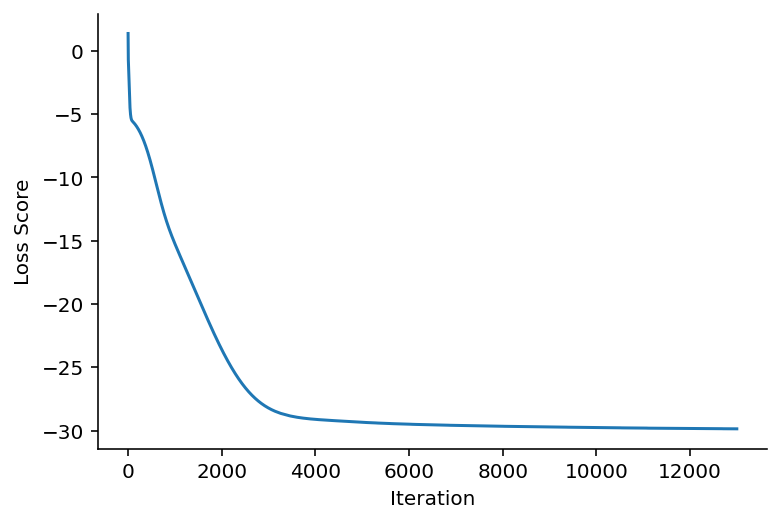

In [53]:
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss Score")
sns.despine()


In [54]:
# Test-drive updated score model
vmap(partial(updated_score_model, t=ts_noising[-1]))(noising_ys.T[-1])

DeviceArray([ 1.189118  , -0.12900409,  0.0565423 , ...,  0.9671463 ,
              0.04581967,  0.06909027], dtype=float32)

### Sanity-check: score estimators match up with alternate calculation

Because we started with Gaussian noise and expanded the noise outwards,
we still have Gaussians.
Let's check that the scores match a Gaussian's score 
fitted onto the marginal distributions at each timepoint.

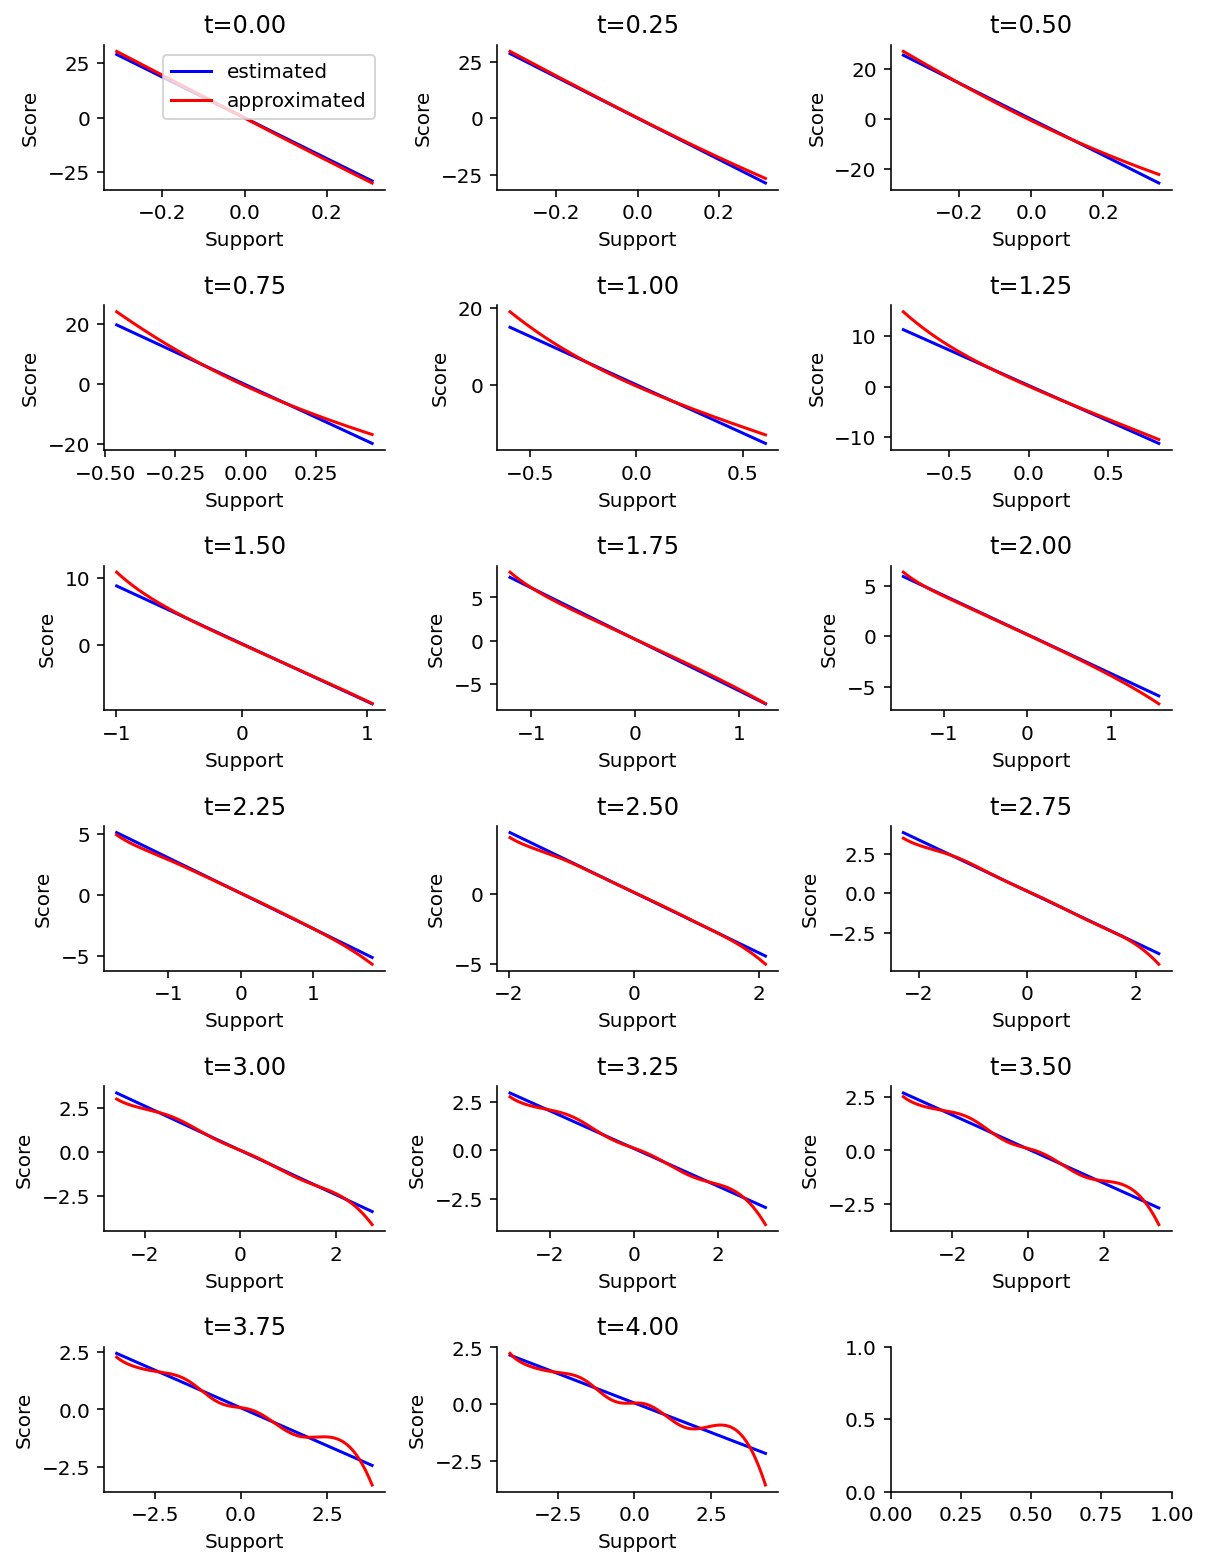

In [55]:
#| code-fold: true
#| fig-cap: Estimated (blue) vs. approximated (red) score functions at each time evaluation. Estimated score comes from taking the location (mean) and scale (stdev) of the observed data, while approximated score comes from the time-based score model.
#| label: fig-score-vs-time
from jax.scipy.stats import norm 
from jax import grad 


fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(8.5, 11))

for t, noised_ys, ax in zip(ts_noising, noising_ys.T, axes.flatten()):
    plt.sca(ax)
    noised_ys_mu = np.mean(noised_ys)
    noised_ys_sigma = np.std(noised_ys)

    logp_func = partial(norm.logpdf, loc=noised_ys_mu, scale=noised_ys_sigma)
    np.sum(logp_func(noised_ys))
    dlogp_func = grad(logp_func)

    support = np.linspace(noised_ys_mu - noised_ys_sigma * 3, noised_ys_mu + noised_ys_sigma * 3, 1000)
    estimated_score = vmap(dlogp_func)(support)
    approximated_score = vmap(partial(updated_score_model, t=t))(support)
    plt.plot(support, estimated_score, color="blue", label="estimated")
    plt.plot(support, approximated_score, color="red", label="approximated")
    plt.xlabel("Support")
    plt.ylabel("Score")
    plt.title(f"t={t:.2f}")
    plt.tight_layout()

plt.sca(axes.flatten()[0])
plt.legend()
sns.despine()


As seen in @fig-score-vs-time,
it looks like our score model is able to approximate a time-dependent score function!
The score function is least well-approximated within the region of 2 sigmas of support,
even if not across the full 3 sigmas.
This is encouraging.
We should also note that the `t=4.00` timepoint is the least well-approximated
compared to the `t=1.00` timepoint.

Now, we're going to look at the reverse drift.
In an SDE, the drift term dictates 
where the system is going to move towards in the next time step.
Let's plot the vector field evaluated at each time step `t`.

In [56]:
def reverse_drift(t: float, y: float, args: tuple):
    f = constant_drift(t, y, args)
    g = time_dependent_diffusion(t, y, args)
    s = updated_score_model(y, t)
    return f - 0.5 * g**2 * s

Let's plot each of these four terms to make sure we get a good feel for what's going on.

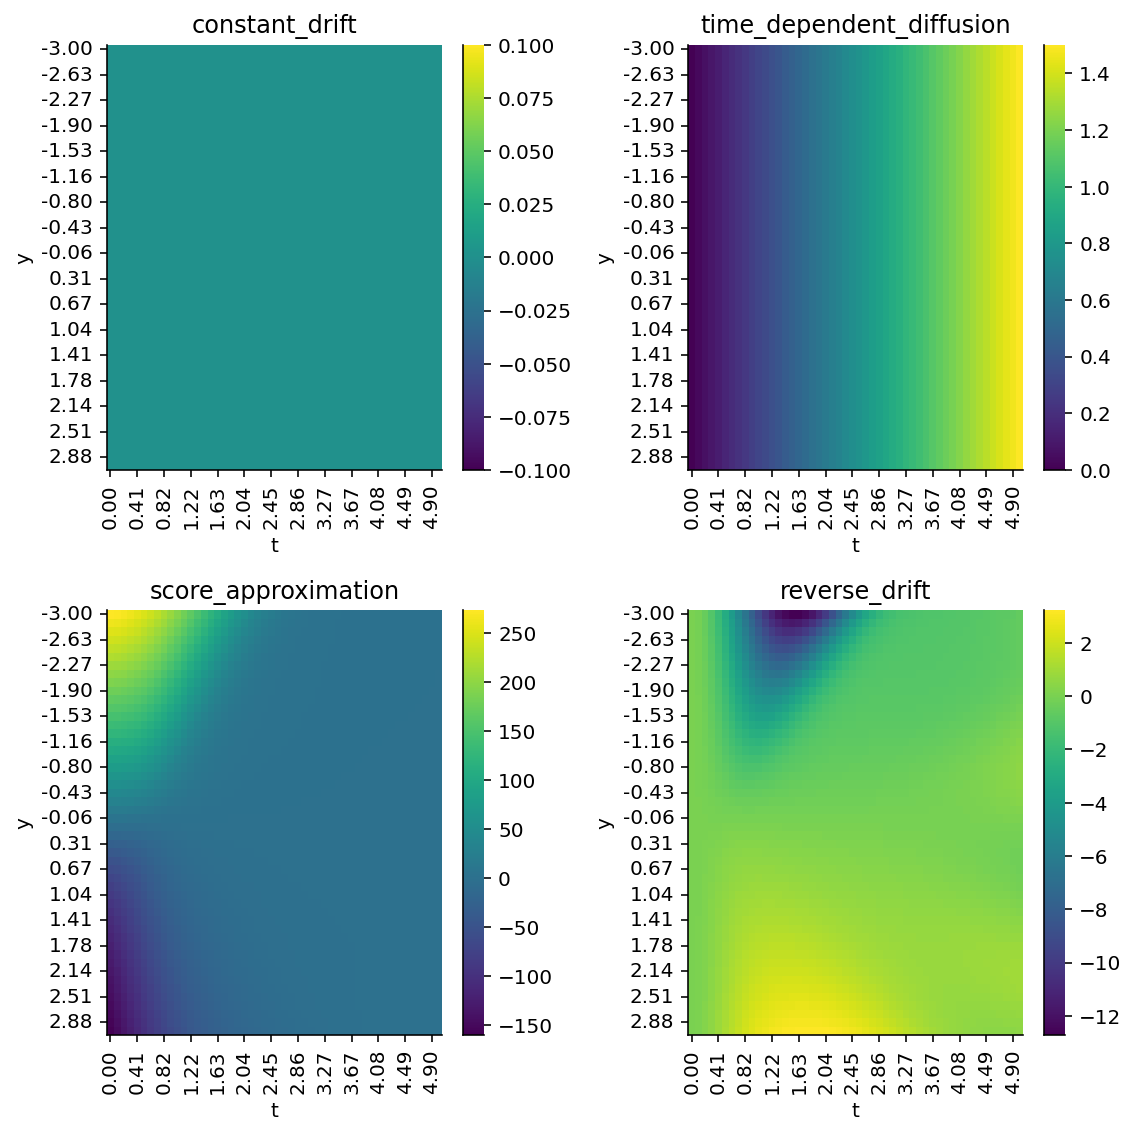

In [57]:
#| code-fold: true
#| label: fig-reverse-sde-components
#| fig-cap: Heatmap of each of the component functions in reverse_drift.

import pandas as pd 
from tqdm.auto import tqdm 

# Plot constant drift as a function of y and t.
ys = np.linspace(-3, 3, 50)
ts = np.linspace(0, 5, 50)

function_evals = []
for yval in ys:
    for t in ts:
        dd = dict()
        dd["constant_drift"] = constant_drift(y=yval, t=t, args=())
        dd["time_dependent_diffusion"] = time_dependent_diffusion(y=yval, t=t, args=())
        dd["score_approximation"] = updated_score_model(x=yval, t=t)
        dd["reverse_drift"] = reverse_drift(y=yval, t=t, args=())
        dd["y"] = (yval)
        dd["t"] = t 
        function_evals.append(dd)

columns = ["constant_drift", "time_dependent_diffusion", "score_approximation", "reverse_drift"]

function_df = pd.DataFrame(function_evals)
for column in function_df.columns:
    function_df[column] = function_df[column].astype(float)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for ax, col in zip(axes.flatten(), columns):
    function_eval = function_df[["y", "t", col]].pivot_table(index="y", columns="t", values=col)
    sns.heatmap(function_eval, ax=ax, cmap="viridis")
    ax.set_title(col)
    ax.set_xticklabels([f"{float(i._text):.2f}" for i in ax.get_xticklabels()])
    ax.set_yticklabels([f"{float(i._text):.2f}" for i in ax.get_yticklabels()])

sns.despine()
plt.tight_layout()

- `constant_drift` is always 0, so no problem.
- `time_dependent_diffusion` shows how diffusion increases over time, independent of the value of `y`, which is also correct, so no problem.
- `score_approximation` shows how the Gaussian score approximator gives a gradient that is positive-valued when `y` is negative and vice versa, which pushes us towards region of high density. Also correct.
- `reverse_drift` shows us something interesting. We will end up with exploding values because +ve values drift more positive, while -ve values drift more -ve, until we hit very small time steps, and then we have no directional drift.

Now, we could, in theory, run the SDE in reverse,
but in my own testing of the equations, 
I found that I would encounter numerical stability issues.
Because of the positive and negative drift zones in the reverse drift,
we would end up getting extremely large negative or positive numbers.
Hence, I skipped over solving the reverse SDE 
and instead went straight to probability flow ODEs,
which are the very, very exciting piece of this entire body of work.

## Probability Flow ODEs

Now that we've recapped what an ODE is, 
and have seen what SDEs can do for noising up our data,
we can move on to probability flow ODEs.
Why are these important? 
It's because probability flow ODEs 
provide a deterministic mapping from our noise distribution to our data distribution
and vice versa.
In doing so, we can basically get rid of Langevin dynamics sampling
and replace it entirely with a probability flow ODE instead.
Before we go on, though, let's examine what probability flow ODEs are.
Probability flow ODEs have the following form:

$$dx = [f(x,t) - \frac{1}{2} g^2(t) \nabla_x \log p_t (x)] dt$$


Just like the SDE above, the terms carry the same meaning:

> - $f(x, t)$ is a drift function that produces a vector output,
> - $g(t)$ is a diffusion function that produces a scalar output,
> - and $dw$ is infinitesimal white noise.  
> 
> (paraphrased from Yang's blog)


Now, if you study this carefully... 
the drift term is _exactly_ the drift term we defined above!
That means if we solve for the reverse drift ODE,
we will get a path traced from the noise distribution
back to the orginal data distribution!
Let's see that in action.

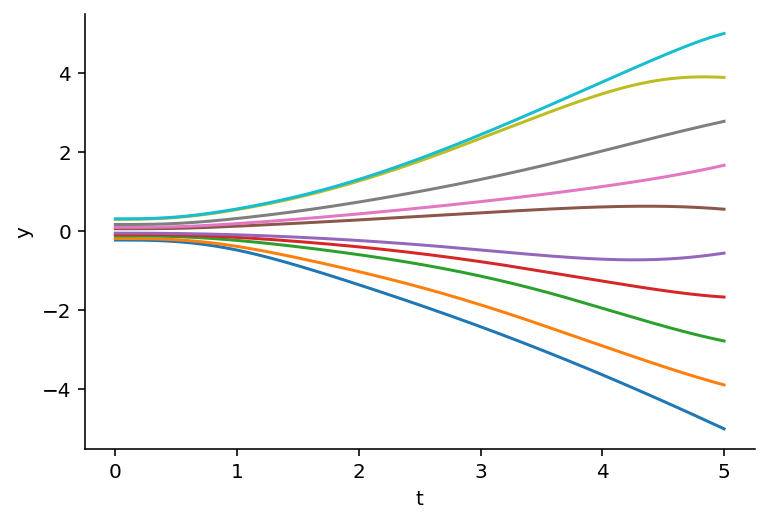

In [58]:
#| fig-cap: Probability flow ODE from noise distribution (t=5) back to original data (t=0).
#| label: fig-prob-flow-ode

ode_combined = ODE(reverse_drift)

ode = ode_combined
ts = np.linspace(5, 0, 1000)
key = random.PRNGKey(55)
y0s = np.linspace(-5 ,5, 10)

for y0 in y0s:
    ys = ode(ts, y0)
    plt.plot(ts, ys)
plt.xlabel("t")
plt.ylabel("y")
sns.despine()

And just like that, we have:

- An SDE that noises up data (forward-time),
- A score model that estimates the score of the data, and
- A probability flow ODE that maps from noise back to data (reverse-time).

That last point is the coolest of them all, in my opinion.
Instead of doing Langevin dynamics sampling,
all we need to do is solve a neural ODE and we're done!